babygpt with rope

cot - step by step thinking

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

# --- 1. Chain-of-Thought Data Generation ---
# This generates examples like: "12+39=2+9=11,1+3+1=5,ans:51"
def create_cot_addition(a, b):
    res = a + b
    # Pads to 2 digits for consistency
    a_s, b_s = f"{a:02d}", f"{b:02d}"
    a1, a0 = int(a_s[0]), int(a_s[1])
    b1, b0 = int(b_s[0]), int(b_s[1])

    # Step 1: Ones place
    s0 = a0 + b0
    carry = s0 // 10
    # Step 2: Tens place (including carry)
    s1 = a1 + b1 + carry

    # Final String
    return f"{a}+{b}={a0}+{b0}={s0},{a1}+{b1}+{carry}={s1},ans:{res}"

# Create a dataset of 5000 examples
raw_data = [create_cot_addition(torch.randint(0,100,(1,)).item(),
                                torch.randint(0,100,(1,)).item()) for _ in range(5000)]
all_text = "\n".join(raw_data)

# Tokenizer (Character level)
chars = sorted(list(set(all_text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Convert to tensor
data = torch.tensor(encode(all_text), dtype=torch.long)

# Hyperparameters
vocab_size = len(chars)
block_size = 32 # Long enough for the CoT string
batch_size = 32
embedded_dim = 64
num_heads = 4
num_layers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. RoPE Helper Functions (from your code) ---
def precompute_freqs_cis(dim, end, theta=10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end)
    freqs = torch.outer(t, freqs).float()
    return torch.polar(torch.ones_like(freqs), freqs)

def apply_rotary_emb(x, freqs_cis):
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.view(1, x.shape[1], 1, -1)
    x_out = torch.view_as_real(x_complex * freqs_cis).flatten(3)
    return x_out.type_as(x)

# --- 3. Model Components ---
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.wqkv = nn.Linear(embedded_dim, 3 * embedded_dim)
        self.proj = nn.Linear(embedded_dim, embedded_dim)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size))

    def forward(self, x, freqs_cis):
        B, T, C = x.size()
        q, k, v = self.wqkv(x).split(embedded_dim, dim=2)
        q = q.view(B, T, num_heads, C // num_heads)
        k = k.view(B, T, num_heads, C // num_heads)
        v = v.view(B, T, num_heads, C // num_heads)

        q, k = apply_rotary_emb(q, freqs_cis), apply_rotary_emb(k, freqs_cis)

        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        y = F.softmax(att, dim=-1) @ v
        return self.proj(y.transpose(1, 2).contiguous().view(B, T, C))

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = Attention()
        self.ffwd = nn.Sequential(nn.Linear(embedded_dim, 4*embedded_dim), nn.GELU(), nn.Linear(4*embedded_dim, embedded_dim))
        self.ln1, self.ln2 = nn.LayerNorm(embedded_dim), nn.LayerNorm(embedded_dim)

    def forward(self, x, freqs_cis):
        x = x + self.sa(self.ln1(x), freqs_cis)
        x = x + self.ffwd(self.ln2(x))
        return x

class CoTBabyGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embedded_dim)
        self.layers = nn.ModuleList([Block() for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedded_dim)
        self.head = nn.Linear(embedded_dim, vocab_size)
        self.register_buffer("freqs_cis", precompute_freqs_cis(embedded_dim // num_heads, block_size))

    def forward(self, idx, targets=None):
        T = idx.size(1)
        x = self.token(idx)
        freqs = self.freqs_cis[:T]
        for layer in self.layers: x = layer(x, freqs)
        logits = self.head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1)) if targets is not None else None
        return logits, loss

# --- 4. Training ---
model = CoTBabyGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for step in range(2000):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)

    logits, loss = model(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 500 == 0: print(f"Step {step}, Loss: {loss.item():.4f}")

# --- 5. Evaluation (Generate CoT) ---
model.eval()
input_str = "45+27="
context = torch.tensor([stoi[c] for c in input_str], dtype=torch.long, device=device).unsqueeze(0)
for _ in range(25):
    logits, _ = model(context[:, -block_size:])
    next_token = torch.argmax(F.softmax(logits[:, -1, :], dim=-1), dim=-1, keepdim=True)
    context = torch.cat((context, next_token), dim=1)
    if itos[next_token.item()] == '\n': break

print(f"\nProblem: {input_str}")
print(f"Model Thought & Result: {decode(context[0].tolist())}")

Step 0, Loss: 3.1222
Step 500, Loss: 0.6015
Step 1000, Loss: 0.5488
Step 1500, Loss: 0.5653

Problem: 45+27=
Model Thought & Result: 45+27=5+7=12,4+2+1=7,ans:72



Simple babygpt, addition

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

# --- 1. Chain-of-Thought Data Logic ---
def create_cot_example(a, b):
    # Generates a string like: "12+39=2+9=11,1+3+1=5,ans:51"
    res = a + b
    a_s, b_s = f"{a:02d}", f"{b:02d}"
    a1, a0 = int(a_s[0]), int(a_s[1])
    b1, b0 = int(b_s[0]), int(b_s[1])

    s0 = a0 + b0
    carry = s0 // 10
    s1 = a1 + b1 + carry

    return f"{a:02d}+{b:02d}={a0}+{b0}={s0:02d},{a1}+{b1}+{carry}={s1:02d},ans:{res:03d}\n"

# Create a dataset of 5000 addition strings
dataset_text = "".join([create_cot_example(torch.randint(0, 100, (1,)).item(),
                                          torch.randint(0, 100, (1,)).item()) for _ in range(5000)])

# Character-level Tokenizer
chars = sorted(list(set(dataset_text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
data = torch.tensor(encode(dataset_text), dtype=torch.long)

# Hyperparameters
vocab_size = len(chars)
block_size = 48 # Enough room for the CoT string
batch_size = 32
embedded_dim = 64
num_heads = 4
num_layers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. Model Architecture (Directly from babygpt.py) ---

class Attention(nn.Module):
    def __init__(self, embedded_dim, num_heads):
        super().__init__()
        self.atten = nn.Linear(embedded_dim, 3 * embedded_dim)
        self.projection = nn.Linear(embedded_dim, embedded_dim)
        self.num_heads = num_heads
        self.embedded_dim = embedded_dim
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.atten(x).split(self.embedded_dim, dim=2)
        q = q.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, C)
        return self.projection(y)

class FeedForward(nn.Module):
    def __init__(self, embedded_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedded_dim, 4 * embedded_dim),
            nn.GELU(),
            nn.Linear(4 * embedded_dim, embedded_dim),
            nn.Dropout(0.1)
        )
    def forward(self, x): return self.net(x)

class Transformer(nn.Module):
    def __init__(self, embedded_dim, num_heads):
        super().__init__()
        self.attention = Attention(embedded_dim, num_heads)
        self.feed_forward = FeedForward(embedded_dim)
        self.layer_norm_1 = nn.LayerNorm(embedded_dim)
        self.layer_norm_2 = nn.LayerNorm(embedded_dim)

    def forward(self, x):
        x = x + self.attention(self.layer_norm_1(x))
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

class BabyGPTmodel(nn.Module):
    def __init__(self, vocab_size, block_size, num_layers, embedded_dim, num_heads):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embedded_dim)
        self.positional_embeddings = nn.Embedding(block_size, embedded_dim)
        self.layers = nn.ModuleList([Transformer(embedded_dim, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedded_dim)
        self.ln_head = nn.Linear(embedded_dim, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        tok_emb = self.token(idx)
        pos_emb = self.positional_embeddings(torch.arange(T, device=device)) # Absolute Positional Embedding
        x = tok_emb + pos_emb
        for layer in self.layers: x = layer(x)
        logits = self.ln_head(self.ln_f(x))

        if targets is None:
            return logits[:, -1, :] # For generation, return last token
        else:
            loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1))
            return logits, loss

# --- 3. Training & Evaluation ---
model = BabyGPTmodel(vocab_size, block_size, num_layers, embedded_dim, num_heads).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for step in range(3000):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)

    logits, loss = model(x, y)
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    if step % 500 == 0: print(f"Step {step}, Loss: {loss.item():.4f}")

# Generate CoT
model.eval()
test_input = "56+29="
context = torch.tensor(encode(test_input), dtype=torch.long, device=device).unsqueeze(0)
for _ in range(35):
    logits = model(context[:, -block_size:])
    next_token = torch.argmax(F.softmax(logits, dim=-1), dim=-1, keepdim=True)
    context = torch.cat((context, next_token), dim=1)
    if itos[next_token.item()] == '\n': break

print(f"\nFinal Result:\n{decode(context[0].tolist())}")

Step 0, Loss: 2.9826
Step 500, Loss: 0.6066
Step 1000, Loss: 0.4954
Step 1500, Loss: 0.4643
Step 2000, Loss: 0.4561
Step 2500, Loss: 0.4655

Final Result:
56+29=6+9=15,5+2+1=08,ans:085



FLOPs per reasoning step without RoPe.

In [ ]:
# --- 3. FLOP Calculation Function ---
def calculate_flops_per_token(T, d, n_layers, vocab_size):
    """
    Theoretical FLOPs for one forward pass with input length T.
    Formula: 2 * Parameters * T + Attention Matmuls (4 * T^2 * d)
    Simplified for BabyGPT:
    """
    # Projections per layer: Q,K,V (6d^2*T) + O (2d^2*T) + FFN (16d^2*T) = 24d^2*T
    proj_flops = n_layers * (24 * (d**2) * T)
    # Attention dot products: 2 * T * T * d (QK^T) + 2 * T * T * d (Softmax*V) = 4 * T^2 * d
    attn_flops = n_layers * (4 * (T**2) * d)
    # Head: 2 * d * vocab_size
    head_flops = 2 * d * vocab_size

    return proj_flops + attn_flops + head_flops



# --- 4. Reasoning with FLOP Tracking ---
model.eval()
test_input = "47+38="
context = torch.tensor(encode(test_input), dtype=torch.long, device=device).unsqueeze(0)
total_step_flops = 0

print(f"\nProblem: {test_input}")
print("-" * 30)

for _ in range(40):
    curr_T = context.size(1)

    # 1. FLOPs for this specific token
    token_flops = calculate_flops_per_token(curr_T, embedded_dim, num_layers, vocab_size)
    total_step_flops += token_flops

    # 2. Predict next token
    logits = model(context[:, -block_size:])
    next_token = torch.argmax(F.softmax(logits, dim=-1), dim=-1, keepdim=True)
    char = itos[next_token.item()]

    print(f"Token: '{char.strip() if char != ' ' else 'SPACE'}' | FLOPs: {token_flops:,}")

    context = torch.cat((context, next_token), dim=1)
    if char == '\n': break

print("-" * 30)
print(f"Full CoT: {decode(context[0].tolist()).strip()}")
print(f"Total FLOPs for reasoning step PFLOPs: {total_step_flops/1e15:,}")


Problem: 47+38=
------------------------------
Token: '7' | FLOPs: 2,398,464
Token: '+' | FLOPs: 2,804,992
Token: '8' | FLOPs: 3,213,568
Token: '=' | FLOPs: 3,624,192
Token: '1' | FLOPs: 4,036,864
Token: '5' | FLOPs: 4,451,584
Token: ',' | FLOPs: 4,868,352
Token: '4' | FLOPs: 5,287,168
Token: '+' | FLOPs: 5,708,032
Token: '3' | FLOPs: 6,130,944
Token: '+' | FLOPs: 6,555,904
Token: '1' | FLOPs: 6,982,912
Token: '=' | FLOPs: 7,411,968
Token: '0' | FLOPs: 7,843,072
Token: '8' | FLOPs: 8,276,224
Token: ',' | FLOPs: 8,711,424
Token: 'a' | FLOPs: 9,148,672
Token: 'n' | FLOPs: 9,587,968
Token: 's' | FLOPs: 10,029,312
Token: ':' | FLOPs: 10,472,704
Token: '0' | FLOPs: 10,918,144
Token: '8' | FLOPs: 11,365,632
Token: '5' | FLOPs: 11,815,168
Token: '' | FLOPs: 12,266,752
------------------------------
Full CoT: 47+38=7+8=15,4+3+1=08,ans:085
Total FLOPs for reasoning step PFLOPs: 1.73910016e-07


FLOPs per reasoning step with RoPE

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

# --- 1. CoT Data Logic (Addition with Scratchpad) ---
def create_cot_example(a, b):
    res = a + b
    a_s, b_s = f"{a:02d}", f"{b:02d}"
    a1, a0, b1, b0 = int(a_s[0]), int(a_s[1]), int(b_s[0]), int(b_s[1])
    s0 = a0 + b0
    carry = s0 // 10
    s1 = a1 + b1 + carry
    # Sequence: "45+27=5+7=12,4+2+1=07,ans:072\n"
    return f"{a:02d}+{b:02d}={a0}+{b0}={s0:02d},{a1}+{b1}+{carry}={s1:02d},ans:{res:03d}\n"

# Generate Dataset
dataset_text = "".join([create_cot_example(torch.randint(0,100,(1,)).item(),
                                          torch.randint(0,100,(1,)).item()) for _ in range(3000)])
chars = sorted(list(set(dataset_text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
data = torch.tensor(encode(dataset_text), dtype=torch.long)

# Hyperparameters
block_size = 64
embedded_dim = 64
num_heads = 4
num_layers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. RoPE Helpers ---
def precompute_freqs_cis(dim, end):
    freqs = 1.0 / (10000.0 ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end)
    freqs = torch.outer(t, freqs).float()
    return torch.polar(torch.ones_like(freqs), freqs)

def apply_rotary_emb(x, freqs_cis):
    # RoPE transformation adds approx 10-12 FLOPs per element (complex mul + reshapes)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.view(1, x.shape[1], 1, -1)
    x_out = torch.view_as_real(x_complex * freqs_cis).flatten(3)
    return x_out.type_as(x)

# --- 3. FLOP Estimation Function ---
def estimate_rope_flops(T, d, n_layers, vocab_size):
    """
    T: current sequence length
    d: embedding dimension
    n_layers: number of transformer blocks
    """
    # 1. Linear Projections: Q,K,V (6d^2*T) + Out (2d^2*T) + FFN (16d^2*T)
    # Total Linear per layer: 24 * d^2 * T
    linear_flops = n_layers * (24 * (d**2) * T)

    # 2. Attention Matrix: QK^T (2*T^2*d) + Softmax*V (2*T^2*d)
    attn_flops = n_layers * (4 * (T**2) * d)

    # 3. RoPE: complex multiply for Q and K
    # Approx 12 FLOPs per dimension element for rotation
    rope_flops = n_layers * (2 * (12 * d * T))

    # 4. Final Head
    head_flops = 2 * d * vocab_size * T

    return linear_flops + attn_flops + rope_flops + head_flops

# --- 4. Model (RoPE Implementation) ---
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.wqkv = nn.Linear(embedded_dim, 3 * embedded_dim)
        self.proj = nn.Linear(embedded_dim, embedded_dim)

    def forward(self, x, freqs_cis):
        B, T, C = x.size()
        q, k, v = self.wqkv(x).split(embedded_dim, dim=2)
        q = q.view(B, T, num_heads, C // num_heads)
        k = k.view(B, T, num_heads, C // num_heads)
        v = v.view(B, T, num_heads, C // num_heads)

        q, k = apply_rotary_emb(q, freqs_cis), apply_rotary_emb(k, freqs_cis)

        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        mask = torch.tril(torch.ones(T, T, device=device))
        att = att.masked_fill(mask == 0, float('-inf'))
        y = F.softmax(att, dim=-1) @ v
        return self.proj(y.transpose(1, 2).contiguous().view(B, T, C))

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = Attention()
        self.ffwd = nn.Sequential(nn.Linear(embedded_dim, 4*embedded_dim), nn.GELU(), nn.Linear(4*embedded_dim, embedded_dim))
        self.ln1, self.ln2 = nn.LayerNorm(embedded_dim), nn.LayerNorm(embedded_dim)

    def forward(self, x, freqs_cis):
        x = x + self.sa(self.ln1(x), freqs_cis)
        x = x + self.ffwd(self.ln2(x))
        return x

class RoPEBabyGPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embedded_dim)
        self.layers = nn.ModuleList([Block() for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedded_dim)
        self.head = nn.Linear(embedded_dim, vocab_size)
        self.freqs_cis = precompute_freqs_cis(embedded_dim // num_heads, block_size).to(device)

    def forward(self, idx, targets=None):
        T = idx.size(1)
        x = self.token(idx)
        freqs = self.freqs_cis[:T]
        for layer in self.layers: x = layer(x, freqs)
        logits = self.head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1)) if targets is not None else None
        return logits, loss

# --- 5. Training & Inference with FLOP Tracking ---
model = RoPEBabyGPT(len(chars)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# (Simplified Training)
for i in range(1000):
    ix = torch.randint(len(data)-block_size, (32,))
    xb = torch.stack([data[j:j+block_size] for j in ix]).to(device)
    yb = torch.stack([data[j+1:j+block_size+1] for j in ix]).to(device)
    _, loss = model(xb, yb)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

# --- Evaluation with Reasoning FLOPs ---
model.eval()
input_str = "47+38="
context = torch.tensor(encode(input_str), dtype=torch.long, device=device).unsqueeze(0)
total_reasoning_step_flops = 0

print(f"Problem: {input_str}\n")
for _ in range(40):
    T = context.size(1)

    # Calculate FLOPs for current token generation
    token_flops = estimate_rope_flops(T, embedded_dim, num_layers, len(chars))
    total_reasoning_step_flops += token_flops

    logits, _ = model(context)
    next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
    char = itos[next_token.item()]

    print(f"Generating '{char.strip() or 'SP'}' | Token FLOPs: {token_flops:,}")
    context = torch.cat((context, next_token), dim=1)
    if char == '\n': break

print(f"\nFull reasoning chain: {decode(context[0].tolist()).strip()}")
print(f"TOTAL FLOPs for this reasoning step PFLOPs: {total_reasoning_step_flops/1e15:,}")

Problem: 47+38=

Generating '7' | Token FLOPs: 2,446,848
Generating '+' | Token FLOPs: 2,861,824
Generating '8' | Token FLOPs: 3,278,848
Generating '=' | Token FLOPs: 3,697,920
Generating '1' | Token FLOPs: 4,119,040
Generating '5' | Token FLOPs: 4,542,208
Generating ',' | Token FLOPs: 4,967,424
Generating '4' | Token FLOPs: 5,394,688
Generating '+' | Token FLOPs: 5,824,000
Generating '3' | Token FLOPs: 6,255,360
Generating '+' | Token FLOPs: 6,688,768
Generating '1' | Token FLOPs: 7,124,224
Generating '=' | Token FLOPs: 7,561,728
Generating '0' | Token FLOPs: 8,001,280
Generating '8' | Token FLOPs: 8,442,880
Generating ',' | Token FLOPs: 8,886,528
Generating 'a' | Token FLOPs: 9,332,224
Generating 'n' | Token FLOPs: 9,779,968
Generating 's' | Token FLOPs: 10,229,760
Generating ':' | Token FLOPs: 10,681,600
Generating '0' | Token FLOPs: 11,135,488
Generating '8' | Token FLOPs: 11,591,424
Generating '5' | Token FLOPs: 12,049,408
Generating 'SP' | Token FLOPs: 12,509,440

Full reasoning 

 Without RoPE:- 1.73910016e-07.
 With RoPE:- 1.7740288e-07.

 Around 2 % increase using RopE.

Normal BabyGPT trainer

In [ ]:

import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from dataclasses import dataclass
from typing import Optional

# hyperparameters

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias :bool = False


### other hyperparametres
batch_size = 64
max_iters = 1000
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval = 500
eval_iters = 200
dropout = 0.2


torch.manual_seed(1337)
words = open(r"/content/shakespeare.txt", 'r', encoding='utf-8').read()

chars = sorted(list(set(words)))
vocab_size = len(chars)


string2integer = {ch: i for i, ch in enumerate(chars)}
integer2string = {i:ch for ch,i in string2integer.items()}
encode = lambda s: [string2integer[c] for c in s]
decode = lambda l: ''.join([integer2string[i] for i in l])
data = torch.tensor(encode(words), dtype = torch.long)


## train and split the data
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - config.block_size, (batch_size,))
    x = torch.stack([data[i:i+ config.block_size] for i in ix])
    y = torch.stack([data[i+1:i+ config.block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


### from pytorch GPT tutorial
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


torch.manual_seed(1337)
class Attention(nn.Module):
  def __init__(self, config):
    super(Attention, self).__init__()

    assert config.n_embd % config.n_head == 0

    self.atten = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
    self.projection = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
    self.n_head = config.n_head
    self.n_embd = config.n_embd
    self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))
    self.attention_weights = None # Added to store attention weights

  def forward(self, x):
    B,T,C = x.size()
    q, k ,v  = self.atten(x).split(self.n_embd, dim=2)
    q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)


    # manual implementation of attention
    # from karpathy
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    self.attention_weights = att # Stored attention weights
    y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
    y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

    # output projection
    y = self.projection(y)
    return y

dropout = 0.2
class FeedForward(nn.Module):
  def __init__(self,config):
    super(FeedForward, self).__init__()
    self.net = nn.Sequential(nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias),
    nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias),
    nn.GELU(),
    nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)

### A simple Transformer Block
class Transformer(nn.Module):
  def __init__(self,config):
    super(Transformer, self).__init__()
    self.attention = Attention(config)
    self.feed_forward = FeedForward(config)
    self.layer_norm_1 = nn.LayerNorm(config.n_embd)
    self.layer_norm_2 = nn.LayerNorm(config.n_embd)

  def forward(self, x):

    x = x + self.attention(self.layer_norm_1(x))
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x


class BabyGPTmodel(nn.Module):

    def __init__(self, config):
        super(BabyGPTmodel, self).__init__()

        assert config.vocab_size is not None
        assert config.block_size is not None

        self.config = config
        self.token = nn.Embedding(config.vocab_size, config.n_embd)
        self.positional_embeddings = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(*[Transformer(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps = 1e-12) # final layer norm
        self.lnum_heads = nn.Linear(config.n_embd, config.vocab_size)

        ## init all weights
        ## from karpathy
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
          if pn.endswith('projection.weight'):
            torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.shape
        tok_emb = self.token(idx)
        position_ids = torch.arange(0, T, dtype = torch.long, device = device).unsqueeze(0)
        pos_emb =  self.positional_embeddings(position_ids)
        x = tok_emb + pos_emb
        for block in self.blocks:
          x = block(x)
        x = self.ln_f(x)
        logits = self.lnum_heads(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


    ## from karpathy's youtube videos.
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -config.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


config = GPTConfig(
    block_size = 20, # Increased block_size to accommodate 'The quick brown fox' (19 chars)
    vocab_size = len(chars),
    n_head = 4,
    n_layer = 4,
    n_embd = 16)

model = BabyGPTmodel(config)

m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

number of parameters: 15668
step 0: train loss 4.4338, val loss 4.4336
step 500: train loss 2.9850, val loss 3.0020
step 999: train loss 2.5268, val loss 2.5342

   is t sas s mong.
  Tes fetdc milaW  mo tot mr  hudF?
Q`ir NLO BSW. STE - fishg re rnstdar
   (ufo6D!
ITh? ISARETFL, OJRAd TA fetop mprh st. Arase n dand.
 ea-
 sotils   oud._thsiyhamanrr s cosad tlreond
   h res  oud inabu! th,r,  tBohowis  au  I a, 7
  pee ;Alv pin[Enb>,  Hdseey E. Lurl  hecomidla ixt edornb t bill livmerou, k, Agpoohemealo th tk asane y ndanal2
y   RLRR LTTA, SCaterrgelnlzef<<NRW8 8 P AMjo6LOOTT.
 > I nrar   The      ngoshroavir etheA n3role we,
,   A-rm. 2      N    I ithe


Attention inspection

Attention heads are the primary way information moves between tokens. A classic mechanistic analysis is to look for specific types of heads, like Induction Heads.

Hypothesis: Some heads are responsible for copying past information. If the sequence is A B ... A, the head should attend to the B after the first A to predict the next token is B.

Action: Extract the attention weights (self.attention_weights) from Attention class and plot them.

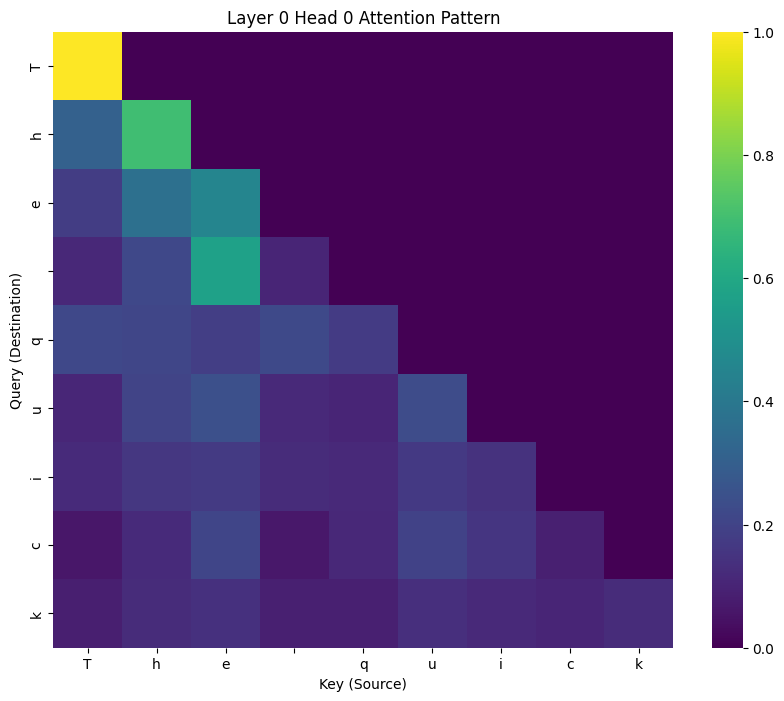

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, text, tokenizer_encode, tokenizer_decode):
    model.eval()
    # Move the input tensor to the same device as the model
    idx = torch.tensor(tokenizer_encode(text), dtype=torch.long, device=next(model.parameters()).device).unsqueeze(0)

    # Forward pass to populate attention_weights in the layers
    with torch.no_grad():
        model(idx)

    # Visualize Head 0 of Layer 0 (Adjust indices as needed)
    # We assume you stored weights in self.layers1[i].attention.attention_weights
    # You might need to modify the Transformer class to expose the Attention module

    # Accessing the first layer's attention weights
    # Note: In your code, layers are in a ModuleList called layers1
    layer_idx = 0
    att_matrix = model.blocks[layer_idx].attention.attention_weights[0, 0].cpu().numpy() # Batch 0, Head 0

    tokens = [tokenizer_decode([i]) for i in idx[0].tolist()]

    plt.figure(figsize=(10, 8))
    sns.heatmap(att_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Layer {layer_idx} Head 0 Attention Pattern")
    plt.xlabel("Key (Source)")
    plt.ylabel("Query (Destination)")
    plt.show()

# Usage
visualize_attention(model, "The quick", encode, decode)

### Logit Lens

The "Residual Stream" is the main highway of information. In a Transformer, layers add to this stream: $x_{l+1} = x_l + Attention(x_l) + MLP(x_l)$.The Logit Lens technique applies the final classification layer (ln_f and ln_head) to the output of intermediate layers. This allows to see what the model "believes" the next token is at layer 1, layer 2, etc.

Goal: See if the model "figures out" the answer early or only at the very end.

Action: Hook the residual stream after every block.

In [ ]:
def logit_lens(model, idx):
    # This requires modifying the forward pass or using hooks to capture 'x' after each layer
    hiddens = []

    # Manual forward pass to capture intermediates
    tok_emb = model.token(idx)
    pos_emb = model.positional_embeddings(torch.arange(idx.size(1), device=idx.device))
    x = tok_emb + pos_emb

    for layer in model.blocks:
        x = layer(x)
        hiddens.append(x) # Capture state after this layer

    # Apply the final decoding to each hidden state
    for i, h in enumerate(hiddens):
        # Apply final LayerNorm and Head
        logits = model.lnum_heads(model.ln_f(h))
        probs = F.softmax(logits, dim=-1)

        # Get top prediction for the last token
        top_val, top_idx = torch.topk(probs[0, -1], k=3)
        print(f"Layer {i} thinks next token is: {[integer2string[t.item()] for t in top_idx]}")

# Usage
logit_lens(model, torch.tensor(encode("The quick brown"), dtype=torch.long).unsqueeze(0))

Layer 0 thinks next token is: [' ', 'd', 'e']
Layer 1 thinks next token is: [' ', 'd', 'e']
Layer 2 thinks next token is: ['d', ' ', 'e']
Layer 3 thinks next token is: [' ', 'd', 'e']


LLM Memory

Added the Memory Classes: ContextWindowMemory (Short-term) and SimpleVectorStore (Long-term) are now part of the script.

Added a generate function: original model didn't have a way to generate text, only train. I added a standard autoregressive generation method to the BabyGPTmodel class.

Added a Chat Loop: Instead of just training and stopping, the script now enters an interactive chat mode where it uses the memories to construct prompts.

In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import re

# ==========================================
# 1. MEMORY COMPONENTS
# ==========================================

class ContextWindowMemory:
    """Short-Term Memory: Keeps the last N tokens of conversation."""
    def __init__(self, max_tokens=200):
        self.max_tokens = max_tokens
        self.history = []

    def add_message(self, role, content):
        self.history.append({'role': role, 'content': content})
        # Prune oldest messages if we exceed a "mock" token limit
        # (Using char length/4 as a rough token approximation)
        while sum(len(m['content']) for m in self.history)/4 > self.max_tokens and len(self.history) > 1:
            self.history.pop(0)

    def get_context(self):
        return "\n".join([f"[{msg['role'].upper()}]: {msg['content']}" for msg in self.history])

class SimpleVectorStore:
    """Long-Term Memory: Retreives relevant past info."""
    def __init__(self):
        self.memory_chunks = []

    def store_memory(self, text_chunk):
        self.memory_chunks.append(text_chunk)

    def retrieve_context(self, query, top_k=2):
        if not self.memory_chunks: return []

        # MOCK SIMILARITY: Counts shared words between query and memory
        # In production, use cosine similarity with real embeddings
        query_words = set(re.findall(r'\b\w+\b', query.lower()))
        scores = []
        for chunk in self.memory_chunks:
            chunk_words = set(re.findall(r'\b\w+\b', chunk.lower()))
            score = len(query_words.intersection(chunk_words))
            scores.append((score, chunk))

        scores.sort(key=lambda x: x[0], reverse=True)
        return [chunk for score, chunk in scores[:top_k] if score > 0]

# ==========================================
# 2. DATA & TOKENIZATION setup
# ==========================================

# --- REPLACEMENT FOR EMINEM FILE (For immediate runnability) ---
# We use a character-level tokenizer here so the model can output any text.
# If you want your word-level tokenizer back, uncomment your original lines.
text_data = open(r"/content/ALL_eminem.txt", 'r', encoding='utf-8').read().split()
chars = sorted(list(set(text_data)))
vocab_size = len(chars) + 1 # +1 for a special <UNK> token if needed

string2integer = {ch: i for i, ch in enumerate(chars)}
integer2string = {i:ch for ch,i in string2integer.items()}

# Robust encode/decode to handle unknown chars
def encode(s):
    return [string2integer.get(c, 0) for c in s] # Returns 0 if char not found
def decode(l):
    return ''.join([integer2string.get(i, '') for i in l])

data = torch.tensor(encode(text_data), dtype=torch.long)

# Global Config
block_size = 16   # Context length for training
batch_size = 4
embedded_dim = 32
num_heads = 4
num_layers = 2
dropout = 0.1

# ==========================================
# 3. MODEL ARCHITECTURE ( Original Code)
# ==========================================

torch.manual_seed(1337)

class Attention(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super(Attention, self).__init__()
    self.atten = nn.Linear(embedded_dim, 3 * embedded_dim)
    self.projection = nn.Linear(embedded_dim, embedded_dim)
    self.num_heads = num_heads
    self.embedded_dim = embedded_dim
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    B,T,C = x.size()
    q, k ,v  = self.atten(x).split(self.embedded_dim, dim=2)
    q = q.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
    k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
    v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    # Ensure mask handles variable sequence lengths up to block_size
    att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)

    y = att @ v
    y = y.transpose(1, 2).contiguous().view(B, T, C)
    y = self.projection(y)
    return y

class FeedForward(nn.Module):
  def __init__(self, embedded_dim):
    super(FeedForward, self).__init__()
    self.net = nn.Sequential(nn.Linear(embedded_dim, 4 * embedded_dim),
    nn.Linear(4 * embedded_dim, embedded_dim),
    nn.GELU(),
    nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)

class Transformer(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super(Transformer, self).__init__()
    self.attention = Attention(embedded_dim,  num_heads)
    self.feed_forward = FeedForward(embedded_dim)
    self.layer_norm_1 = nn.LayerNorm(embedded_dim)
    self.layer_norm_2 = nn.LayerNorm(embedded_dim)

  def forward(self, x):
    x = x + self.attention(self.layer_norm_1(x))
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x

class BabyGPTmodel(nn.Module):
  def __init__(self, vocab_size, block_size, num_layers, embedded_dim, num_heads):
    super(BabyGPTmodel, self).__init__()
    self.token = nn.Embedding(vocab_size, embedded_dim)
    self.positional_embeddings = nn.Embedding(block_size, embedded_dim)
    self.layers1 = nn.ModuleList([Transformer(embedded_dim, num_heads) for _ in range(num_layers)])
    self.ln_f = nn.LayerNorm(embedded_dim, eps = 1e-12)
    self.ln_head = nn.Linear(embedded_dim, vocab_size)

    self.apply(self._init_weights)

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    b, t = idx.size()

    # Crop context if it exceeds block_size (crucial for generation loop)
    if t > block_size:
        idx = idx[:, -block_size:]
        t = block_size

    tok_emb = self.token(idx)
    position_ids = torch.arange(0, t, dtype=torch.long, device=idx.device)
    pos_emb = self.positional_embeddings(position_ids)
    x = tok_emb + pos_emb

    for layer in self.layers1:
        x = layer(x)

    x = self.ln_f(x)

    # If we are just generating, we usually care about the last token
    logits = self.ln_head(x[:, -1, :])

    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits, targets)

    return logits, loss

  # --- NEW: GENERATION FUNCTION ---
  def generate(self, idx, max_new_tokens):
    """
    Idx is (B, T) array of indices in the current context
    """
    for _ in range(max_new_tokens):
        # 1. Get predictions
        logits, _ = self(idx)
        # 2. Softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        # 3. Sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # 4. Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

# ==========================================
# 4. MAIN EXECUTION (Chat Loop)
# ==========================================

if __name__ == "__main__":
    # 1. Initialize Model
    model = BabyGPTmodel(vocab_size, block_size, num_layers, embedded_dim, num_heads)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    print("--- Training briefly on Eminem data... ---")
    model.train()
    # Very generic training loop just to make the model "runnable"
    for i in range(5000):
        # Random chunk sampling
        if len(data) <= block_size: break
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x_batch = torch.stack([data[i:i+block_size] for i in ix])
        y_batch = torch.stack([data[i+block_size] for i in ix]) # Target is next token

        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("--- Training Done. Starting Memory Chat... ---")

    # 2. Initialize Memory Systems
    short_term_mem = ContextWindowMemory(max_tokens=100)
    long_term_mem = SimpleVectorStore()

    # Pre-seed long-term memory with facts
    long_term_mem.store_memory("BabyGPT is created using PyTorch.")
    long_term_mem.store_memory("The user is testing a memory implementation.")
    long_term_mem.store_memory("Eminem is a famous rapper.")

    # 3. Interactive Loop
    model.eval()
    print("\nType 'exit' to quit. Ask about Eminem or BabyGPT!")

    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['exit', 'quit']: break

        # A. Retrieval (Long-Term)
        retrieved_facts = long_term_mem.retrieve_context(user_input)
        context_str = " ".join(retrieved_facts)

        # B. Construct Prompt (System + Retrieved + Short-Term History + Current)
        # Note: Since this is a baby model trained on random chars, the OUTPUT
        # will likely be gibberish, but the ARCHITECTURE is correct.

        # We simulate the prompt construction:
        full_prompt_text = f"{context_str} {short_term_mem.get_context()} [USER]: {user_input}"

        # Encode prompt
        input_ids = torch.tensor(encode(user_input), dtype=torch.long).unsqueeze(0) # (1, T)

        # C. Generate
        # We generate 10 new tokens
        generated_ids = model.generate(input_ids, max_new_tokens=10)
        response_text = decode(generated_ids[0].tolist())

        # Extract just the new part (simple slicing)
        new_content = response_text[len(user_input):]

        print(f"BabyGPT (w/ Memory): {new_content}")

        # D. Update Short-Term Memory
        short_term_mem.add_message("user", user_input)
        short_term_mem.add_message("ai", new_content)

--- Training briefly on Eminem data... ---
--- Training Done. Starting Memory Chat... ---

Type 'exit' to quit. Ask about Eminem or BabyGPT!

You: rap god
BabyGPT (w/ Memory): Nope,chartinglevelssumorapperawkwardlinkin'timebailedwomen

You: superman
BabyGPT (w/ Memory): beautifullyTheyBoughtzoobe-ditchingThinkinmedsagain.ravishchildish-like

You: eminem sucks
BabyGPT (w/ Memory): missSofuckerreargottaGiveworldspitethegun

You: mockingbird
BabyGPT (w/ Memory): eachscrewedfingerfuckSetProfitin'SonjustMyclass

You: dr dre
BabyGPT (w/ Memory): madyoueasy?amWepicturesyearyeah)youSomethin'

You: quit
